# Carga de datos

In [1]:

#------------Montar el Drive y acceder a la API con la key -------------

import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
with open("/content/drive/MyDrive/Data Proyects/kaggle.json", 'r') as f:  
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c analisis-predictivo-2023q1

  0% 0.00/3.83M [00:00<?, ?B/s]
100% 3.83M/3.83M [00:00<00:00, 152MB/s]


In [3]:
#-------- Descomprimir el zip -----------------

import zipfile

import os



os.listdir()



for file in os.listdir():

    if file.endswith('.zip'):

      zip_ref = zipfile.ZipFile(file, 'r')

      zip_ref.extractall()

      zip_ref.close()


In [4]:
import pickle
from tempfile import mkdtemp
from shutil import rmtree

%pip install feature_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from feature_engine.preprocessing import MatchVariables
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.imputation import (
    AddMissingIndicator, MeanMedianImputer, CategoricalImputer, EndTailImputer
)
from feature_engine.transformation import PowerTransformer
from feature_engine.creation import RelativeFeatures
from feature_engine.selection import DropFeatures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 9.7 MB/s eta 0:00:00


In [5]:
import pandas as pd

# Cargar los datos desde el archivo CSV
df = pd.read_csv('base_train.csv')

# Mostrar las primeras 5 filas del DataFrame
print(df.head())


       id           source                                               name  \
0  528022      city scrape                                     Somewhere Else   
1    2818      city scrape          Quiet Garden View Room & Super Fast Wi-Fi   
2   20168  previous scrape       Studio with private bathroom in the centre 1   
3   27886      city scrape  Romantic, stylish B&B houseboat in canal district   
4   28871      city scrape                            Comfortable double room   

                                         description  \
0  Highlights<br />*Located only 5 minutes from C...   
1  Quiet Garden View Room & Super Fast Wi-Fi<br /...   
2  17th century Dutch townhouse in the heart of t...   
3  Stylish and romantic houseboat on fantastic hi...   
4  <b>The space</b><br />In a monumental house ri...   

                               neighborhood_overview  host_id  host_name  \
0                                                NaN  2594559        Els   
1  Indische Buurt ("Indi

#EDA y limpieza

In [6]:
# Obtener información sobre los tipos de datos de cada columna
print(df.dtypes)


print(df.dtypes.nunique()) # Hay 3 tipos de datos str, obj (un dicc) y numericos


id                                                int64
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 68, dtype: object
3


In [7]:
# Obtener estadísticas resumidas sobre las columnas numéricas
print(df.describe())



                 id       host_id  host_listings_count  \
count  4.928000e+03  4.928000e+03          4928.000000   
mean   6.294489e+15  8.186850e+07             2.508929   
std    5.873144e+16  1.114891e+08            10.565612   
min    2.818000e+03  3.159000e+03             1.000000   
25%    1.135244e+07  8.692070e+06             1.000000   
50%    2.437740e+07  2.735878e+07             1.000000   
75%    4.038502e+07  1.056092e+08             2.000000   
max    5.685149e+17  4.865512e+08           363.000000   

       host_total_listings_count  neighbourhood_group_cleansed     latitude  \
count                4928.000000                           0.0  4928.000000   
mean                    4.768872                           NaN    52.367291   
std                    28.580679                           NaN     0.016869   
min                     1.000000                           NaN    52.290340   
25%                     1.000000                           NaN    52.356657   
50%

In [ ]:
print(df.columns)

Index(['id' Se queda es num, 
        'source' cat ,
        'name',
        'description' SA y la remplazo con eso,
        'neighborhood_overview' frec encoding,
      
       'host_id' num ,
      
        'host_name' cat,
       
        'host_since' la transformo,
      
       'host_location' cat,
       
        'host_about' ,
      
       'host_response_time' num, 
       
       'host_response_rate' pongo en num ,
       
        'host_acceptance_rate' a num,
       
       'host_is_superhost' cat,
        
        'host_neighbourhood' freq encod, 
        
        'host_listings_count' num,
       'host_total_listings_count' num, 
       'host_verifications' a num contando el largo,
      
       'host_has_profile_pic' cat,
        'host_identity_verified' cat,

         'neighbourhood'freq encod,
       'neighbourhood_cleansed' freq encod,

        'neighbourhood_group_cleansed' chau,

         'latitude' num,
       'longitude' num,

        'property_type' cat,
         'room_type'cat,

          'accommodates' num,

           'bathrooms' chau,
       
       'bathrooms_text' transform,

        'bedrooms' num,
         'beds'num,

          'amenities' transform,

           'price' transform,

       'minimum_nights'num,
        'maximum_nights'num,
         'minimum_minimum_nights'num,
       'maximum_minimum_nights'num,
        'minimum_maximum_nights'num,
       'maximum_maximum_nights'num,
        'minimum_nights_avg_ntm'num,
       'maximum_nights_avg_ntm'num,

        'calendar_updated'chau,

         'has_availability' cat,

sumarlas y hacer un popularity score (al final la que menos suma es la que mas popular
       'availability_30',
        'availability_60',
         'availability_90',
       'availability_365',

        'calendar_last_scraped'chau,
num
         'number_of_reviews',
       'number_of_reviews_ltm',
        'number_of_reviews_l30d',


fechas
         'first_review' saco dif,
       'last_review' saco dif,

        'review_scores_rating' target,
         
num         
         'review_scores_accuracy',
       'review_scores_cleanliness',
        'review_scores_checkin',
       'review_scores_communication',
        'review_scores_location',
       'review_scores_value',

cat
        'license' cat,
         'instant_bookable' cat,
num
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms',
        'reviews_per_month'],
      dtype='object')

In [ ]:
print(df['availability_365'][3])

40


In [ ]:
for column in df:
  print(df[column][1])
  #print(column[1].dtypes)

In [ ]:
print(df['bathrooms_text'].dtypes)

In [ ]:
print(df.info())

#print(df['neighbourhood_cleansed'].unique)



In [8]:
df_numeric = df.select_dtypes(include=['int', 'float'])

df_obj = df.select_dtypes(include=['object'])

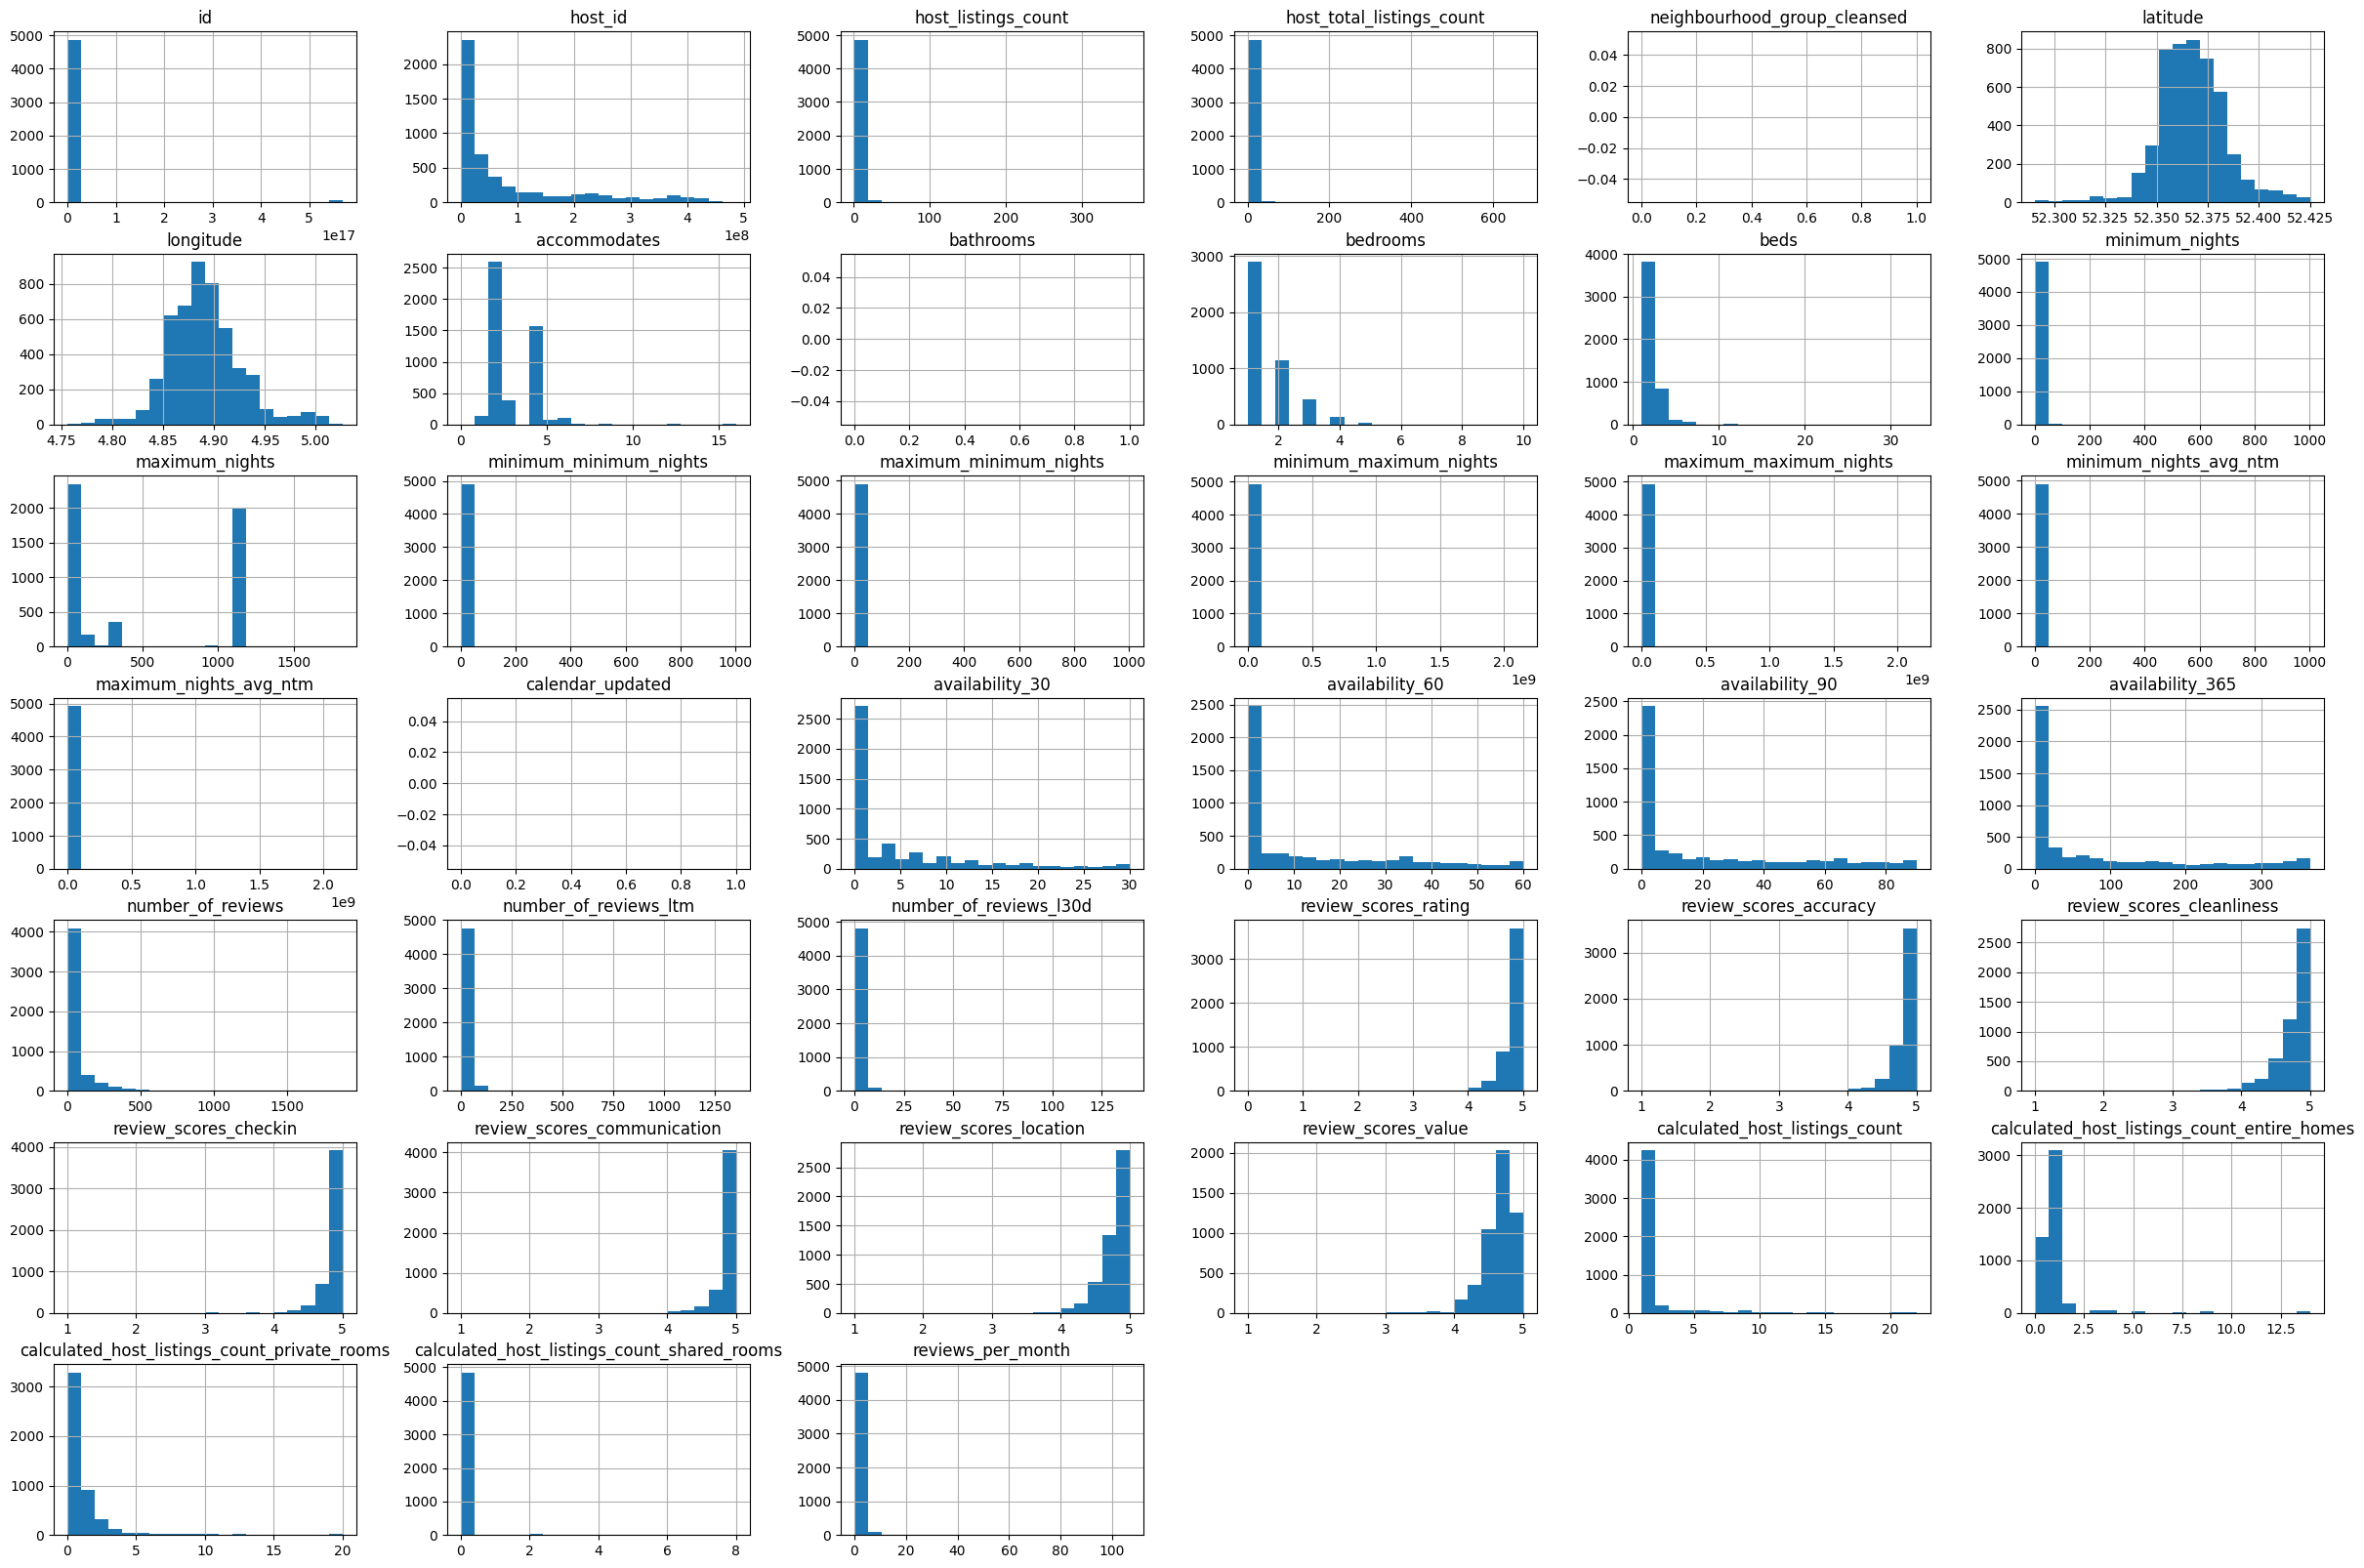

In [9]:
import matplotlib.pyplot as plt

df_numeric.hist(bins=20, figsize=(30,20))

# Ajustar las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar variables de interés
cols = [col for col in df.columns if col.startswith('review')] + ['property_type', 'price']
df_reviews_price = df[cols]

print(df_reviews_price)

# Graficar
for col in df_reviews_price:
    sns.relplot(data=df_reviews_price, x=col, y='price', hue='property_type', kind='scatter')


<ipython-input-6-a9bacf5d6854>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


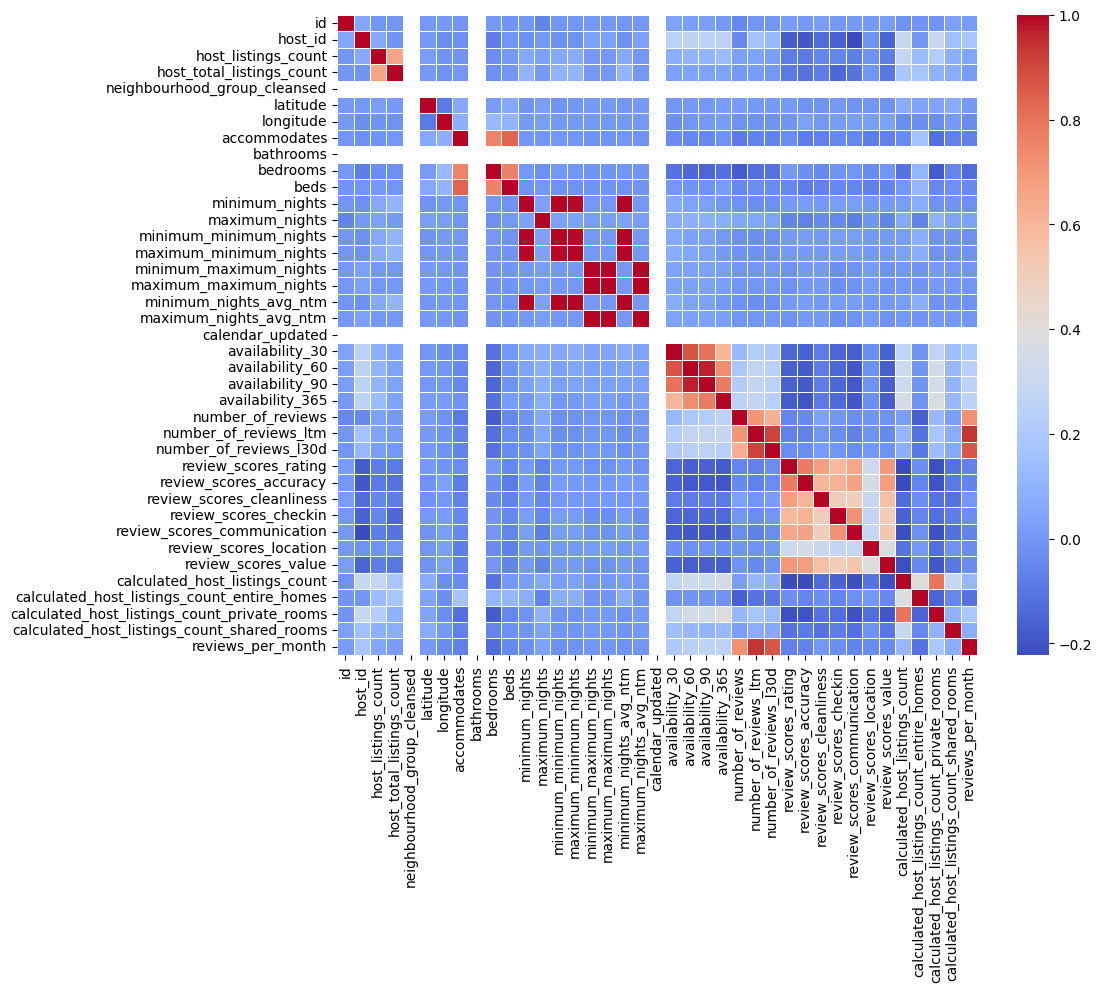

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear el corr plot utilizando seaborn
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Ajustar los márgenes del gráfico
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

# Mostrar el gráfico
plt.show()


In [ ]:
id=df['id']

Con el dataset ya transformado voy a usar df_train para ver relaciones no lineales graficamente.

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura con múltiples subtramas
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))

# Obtener el nombre de las columnas en el dataframe 
column_names = df_train.columns

# Iterar sobre las subtramas y las columnas del dataframe
for i, ax in enumerate(axes.flatten()):
    if i < len(column_names):
        # Crear el gráfico de dispersión
        ax.scatter(df_train[column_names[i]], df_train[target_variable], s=10)
        ax.set_xlabel(column_names[i])
        ax.set_ylabel('review_score_rating')
    
# Ajustar los espacios entre subtramas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

No se pudo ver a simple vista

# Transformacion






In [ ]:
#Trabajo las fechas

#antiguedad host

df['host_since'] = pd.to_datetime(df['host_since'])

import datetime
current_date = datetime.datetime.now().date()

df['antiguedad_host'] = (current_date - df['host_since'].dt.date).dt.days

#primer review antiguedad

df['first_review'] = pd.to_datetime(df['first_review'])

df['antiguedad_primer_review'] = (current_date - df['first_review'].dt.date).dt.days

#antiguedad ultimo review

df['last_review'] = pd.to_datetime(df['last_review'])

df['antiguedad_last_review'] = (current_date - df['last_review'].dt.date).dt.days

In [ ]:
df['amenities_score'] = df['amenities'].apply(lambda x: len(x))


In [ ]:
df_numeric = df.select_dtypes(include=['int', 'float'])

df_obj = df.select_dtypes(include=['object'])

#print(df_obj.head())

print(df_numeric.head())

Arreglar bathrooms

In [ ]:
def limpiar_baños(texto):
    cantidad_baños = None

    if isinstance(texto, float):
        texto = str(texto)
    
    if ' bath' in texto:
        partes = texto.split(' ')
        cantidad_baños = float(partes[0])

    return cantidad_baños

def extraer_privacidad_baño(texto):
    privacidad_baño = None
    
    if isinstance(texto, float):
        texto = str(texto)

    if 'shared' in texto:
        privacidad_baño = 'shared'
    elif 'private' in texto:
        privacidad_baño = 'private'
    else:
        privacidad_baño = 'no info'
    
    return privacidad_baño

df['cantidad_baños'] = df['bathrooms_text'].apply(limpiar_baños)
df['privacidad_baño'] = df['bathrooms_text'].apply(extraer_privacidad_baño)


In [ ]:
print(df['property_type'].nunique())


#Sino me equivoco cada valor que es type object es un dicc con los valores en general son string, por ejemplo precio es '$400'por ejemplo asi que habria que trabajarlo 

def convert_price_to_float(price):
    try:
        price = price.replace('$', '').strip() # Eliminar símbolos de moneda y espacios en blanco
        price = float(price) # Convertir a un tipo numérico (float)
        return price
    except:
        return None # Devolver None si no se puede convertir a un tipo numérico

df['price'] = df['price'].apply(lambda x: convert_price_to_float(x)) # Aplicar la función a la columna 'price'



#df_numeric['price'] = df['price'].copy()

#df['price'] = df['price'].round(1)

# Filtrar todas las filas donde el precio es mayor a 200 dólares
#filtro_precio = df['price'] > 50
#print(df[filtro_precio])

# Agrupar por tipo de propiedad y calcular el precio promedio
precio_promedio_por_propiedad = df.groupby('property_type')['price'].mean()
print(precio_promedio_por_propiedad)


In [ ]:
from textblob import TextBlob

# Define una función para obtener el puntaje de sentimiento de un texto
def get_sentiment_score(text):
    if isinstance(text, str):
        blob = TextBlob(text)
        return blob.sentiment.polarity
    else:
        return None

# Aplica la función a la columna "neighborhood_overview" y crea una nueva columna "sentiment_score_neighbouhood" y lo mismo para "description"que describe la propiedad
df['sentiment_score_neighborhood'] = df['neighborhood_overview'].apply(lambda x: get_sentiment_score(x))

df['sentiment_score_description'] = df['description'].apply(lambda x: get_sentiment_score(x))

#Lo bueno es que esto lo puedo imputar con las numericas para sacar los NaN


In [ ]:
response_time_mapping = {
    "within an hour": 1,
    "within a few hours": 2,
    "within a day": 3,
    "a few days or more": 4
}

df['host_response_time_numeric'] = df['host_response_time'].map(response_time_mapping)


In [ ]:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float) / 100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype(float) / 100


##NA y Missing

calendar updated son todos nan


In [ ]:
# Calcular la cantidad de valores faltantes por columna
missing_values = df.isna().sum()

# Seleccionar las columnas con más de 500 valores faltantes
cols_to_drop = ["neighbourhood_group_cleansed","calendar_updated", "bathrooms","bathrooms_text"]  #Elimino estas 3 columnas porque todas sus columna son valores null por lo que molestan el analsisis
#Ademas la info de bathrooms la calcule aparte , neighbourhood uso la columna no agrupada y calendar no es util pq es NaN

# Imprimir las columnas a eliminar
print(missing_values)

# Eliminar las columnas con más de 500 valores faltantes
df = df.drop(cols_to_drop, axis=1)



id                                 0
source                             0
name                               0
description                        3
neighborhood_overview           1348
                                ... 
cantidad_baños                    18
privacidad_baño                    0
sentiment_score_neighborhood    1348
sentiment_score_description        3
host_response_time_numeric      1662
Length: 77, dtype: int64


In [ ]:
df_numeric = df.select_dtypes(include=['int', 'float'])

df_obj = df.select_dtypes(include=['object'])

print(df_obj.head())

print(df_numeric.head())

            source                                               name  \
0      city scrape                                     Somewhere Else   
1      city scrape          Quiet Garden View Room & Super Fast Wi-Fi   
2  previous scrape       Studio with private bathroom in the centre 1   
3      city scrape  Romantic, stylish B&B houseboat in canal district   
4      city scrape                            Comfortable double room   

                                         description  \
0  Highlights<br />*Located only 5 minutes from C...   
1  Quiet Garden View Room & Super Fast Wi-Fi<br /...   
2  17th century Dutch townhouse in the heart of t...   
3  Stylish and romantic houseboat on fantastic hi...   
4  <b>The space</b><br />In a monumental house ri...   

                               neighborhood_overview  host_name  \
0                                                NaN        Els   
1  Indische Buurt ("Indies Neighborhood") is a ne...     Daniel   
2  Located just in betw

In [ ]:
from sklearn.impute import SimpleImputer

# Obtener las columnas categóricas
categorical_columns = df.select_dtypes(include='object').columns

# Crear el imputador por moda
imputer = SimpleImputer(strategy='most_frequent')

# Imputar los valores faltantes en las variables categóricas
df[categorical_columns] = imputer.fit_transform(df[categorical_columns])

df[categorical_columns].info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4928 entries, 0 to 4927
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   source                  4928 non-null   object
 1   name                    4928 non-null   object
 2   description             4928 non-null   object
 3   neighborhood_overview   4928 non-null   object
 4   host_name               4928 non-null   object
 5   host_location           4928 non-null   object
 6   host_about              4928 non-null   object
 7   host_response_time      4928 non-null   object
 8   host_is_superhost       4928 non-null   object
 9   host_neighbourhood      4928 non-null   object
 10  host_verifications      4928 non-null   object
 11  host_has_profile_pic    4928 non-null   object
 12  host_identity_verified  4928 non-null   object
 13  neighbourhood           4928 non-null   object
 14  neighbourhood_cleansed  4928 non-null   object
 15  prop

In [ ]:
df_numeric = df.select_dtypes(include=['int', 'float'])

df_obj = df.select_dtypes(include=['object'])

#print(df_obj.head())

print(df_numeric)

                      id    host_id  host_response_rate  host_acceptance_rate  \
0                 528022    2594559                0.87                  0.96   
1                   2818       3159                1.00                  1.00   
2                  20168      59484                1.00                  0.98   
3                  27886      97647                1.00                  1.00   
4                  28871     124245                1.00                  1.00   
...                  ...        ...                 ...                   ...   
4923  567407960487712181   23030993                0.70                  0.27   
4924  567829002669570759   55892903                1.00                  0.67   
4925  567927199868989828  446310915                1.00                  1.00   
4926  567958632398468204  204029682                 NaN                  1.00   
4927  568514877303578111   23704127                 NaN                  0.82   

      host_listings_count  

In [ ]:
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import CountFrequencyEncoder



vars_cat=['neighborhood_overview','neighbourhood_cleansed','property_type','room_type','privacidad_baño', 'host_neighbourhood','host_name', 'host_location', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']

#ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
frecuency_transformer = CountFrequencyEncoder(encoding_method='frequency')


transformer = ColumnTransformer(
        transformers=[
        #('ordinal_encoder', ordinal_encoder, vars_cat)
        ('frecuency_transformer', frecuency_transformer, vars_cat)
        ],remainder='passthrough')

# Aplicar las transformaciones y actualizar el DataFrame
df[vars_cat] = transformer.fit_transform(df[vars_cat])

print(df_obj.head())

print(df_numeric.head())

print(df[vars_cat].head())

            source                                               name  \
0      city scrape                                     Somewhere Else   
1      city scrape          Quiet Garden View Room & Super Fast Wi-Fi   
2  previous scrape       Studio with private bathroom in the centre 1   
3      city scrape  Romantic, stylish B&B houseboat in canal district   
4      city scrape                            Comfortable double room   

                                         description  \
0  Highlights<br />*Located only 5 minutes from C...   
1  Quiet Garden View Room & Super Fast Wi-Fi<br /...   
2  17th century Dutch townhouse in the heart of t...   
3  Stylish and romantic houseboat on fantastic hi...   
4  <b>The space</b><br />In a monumental house ri...   

                               neighborhood_overview  host_name  \
0  Traditionally a blue collar neighbourhood just...        Els   
1  Indische Buurt ("Indies Neighborhood") is a ne...     Daniel   
2  Located just in betw

In [ ]:
df_numeric = df.select_dtypes(include=['int', 'float'])

df_obj = df.select_dtypes(include=['object'])

#print(df_obj.head())

print(df_numeric)

                      id  neighborhood_overview    host_id  host_name  \
0                 528022               0.277192    2594559   0.000406   
1                   2818               0.000203       3159   0.001218   
2                  20168               0.000203      59484   0.002638   
3                  27886               0.000203      97647   0.000203   
4                  28871               0.000203     124245   0.001420   
...                  ...                    ...        ...        ...   
4923  567407960487712181               0.277192   23030993   0.002435   
4924  567829002669570759               0.277192   55892903   0.000609   
4925  567927199868989828               0.277192  446310915   0.000812   
4926  567958632398468204               0.000203  204029682   0.000203   
4927  568514877303578111               0.000203   23704127   0.001218   

      host_location  host_response_rate  host_acceptance_rate  \
0          0.939326                0.87                  0

La idea de KNN estaba buena pero a la hora de trabajar con val era muy molesta.

In [ ]:
#from sklearn.impute import KNNImputer
#from sklearn.preprocessing import MinMaxScaler

# Definir un subconjunto del dataset sin la variable "review_scores_rating"
#df_knn = df_numeric.drop("review_scores_rating", axis=1)

# Definir el escalador para establecer los valores entre 0 y 1
#scaler = MinMaxScaler(feature_range=(0, 1))
#df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns=df_knn.columns)

# Definir el KNNImputer y completar los valores faltantes
#knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
#df_numeric = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


In [ ]:
from sklearn.impute import SimpleImputer

# Crear el imputador con la estrategia de relleno "mean" (media)
imputer = SimpleImputer(strategy='mean')

# Rellenar los valores faltantes con la media
df_numeric = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)


In [ ]:
print(df['neighbourhood_cleansed'].info)

<bound method Series.info of 0       0.069399
1       0.040381
2       0.101461
3       0.146713
4       0.146713
          ...   
4923    0.156859
4924    0.156859
4925    0.009334
4926    0.156859
4927    0.017451
Name: neighbourhood_cleansed, Length: 4928, dtype: float64>


In [ ]:
df[categorical_columns].info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4928 entries, 0 to 4927
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   source                  4928 non-null   object 
 1   name                    4928 non-null   object 
 2   description             4928 non-null   object 
 3   neighborhood_overview   4928 non-null   float64
 4   host_name               4928 non-null   float64
 5   host_location           4928 non-null   float64
 6   host_about              4928 non-null   object 
 7   host_response_time      4928 non-null   object 
 8   host_is_superhost       4928 non-null   float64
 9   host_neighbourhood      4928 non-null   float64
 10  host_verifications      4928 non-null   object 
 11  host_has_profile_pic    4928 non-null   float64
 12  host_identity_verified  4928 non-null   float64
 13  neighbourhood           4928 non-null   object 
 14  neighbourhood_cleansed  4928 non-null   

#Modelo 

In [ ]:
# Definir la variable objetivo
target_variable = 'review_scores_rating'

df_train=df_numeric

###DesisiconTreeRegresor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error



# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_numeric.drop(target_variable, axis=1)
y = df_numeric[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(X_train.columns)

# Crear el modelo de árbol de decisión
model = DecisionTreeRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.02398225152129817


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

R^2 Score: 0.5340327231234792


###XGBoost

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error



# Eliminar las filas con valores faltantes
df_numeric.dropna(inplace=True)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_numeric.drop(target_variable, axis=1)
y = df_numeric[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(X_train.columns)

# Crear el modelo de árbol de decisión
model = XGBRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.01576876469546196


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

R^2 Score: 0.6936180767545677


###Bagging Tree

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Crear el modelo de árbol de decisión base
base_model = DecisionTreeRegressor()

# Crear el modelo Bagging
model = BaggingRegressor(base_model, n_estimators=20, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 0.0125118395030426


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

R^2 Score: 0.7568990644280735


##LGBM

In [ ]:
import lightgbm as lgb

# Crear el modelo LightGBM
model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

Mean Squared Error: 0.015144211074893686
R^2 Score: 0.7057529486443532


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'num_leaves': [20, 30, 40],
    'max_depth': [3, 5, 7],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

# Crear el modelo LightGBM
model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores parámetros
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

# Imprimir los mejores parámetros encontrados
print('Best Parameters:', best_params)


Mean Squared Error: 0.014248670976105377
R^2 Score: 0.7231529988771486
Best Parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 20, 'n_estimators': 300, 'min_child_samples': 30, 'max_depth': 5, 'learning_rate': 0.01}


In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Definir los mejores parámetros encontrados
best_params = {
    'reg_lambda': [0.1],
    'reg_alpha': [0.5],
    'num_leaves': [20],
    'n_estimators': [300],
    'min_child_samples': [30],
    'max_depth': [5],
    'learning_rate': [0.01]
}

# Crear el modelo LightGBM
model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Realizar la búsqueda en cuadrícula de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=best_params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

# Imprimir los mejores parámetros encontrados
print('Best Parameters:', best_params)


Mean Squared Error: 0.014248670976105377
R^2 Score: 0.7231529988771486
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 300, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.1}


In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Definir los mejores parámetros encontrados
best_params = {
    'reg_lambda': [0.1],
    'reg_alpha': [0.5],
    'num_leaves': [20],
    'n_estimators': [300],
    'min_child_samples': [30],
    'max_depth': [5],
    'learning_rate': [0.01]
}

# Crear el modelo LightGBM
model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Realizar la búsqueda en cuadrícula de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=best_params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores parámetros
model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

# Imprimir los mejores parámetros encontrados
print('Best Parameters:', best_params)



Mean Squared Error: 0.014248670976105377
R^2 Score: 0.7231529988771486
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 300, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.1}


In [ ]:
import lightgbm as lgb

# Crear el modelo LightGBM
model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importance = model.feature_importances_

# Obtener el nombre de las características
feature_names = X_train.columns

# Crear un dataframe con la importancia de las características
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar las características por su importancia de forma descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Imprimir la importancia de las características
print(feature_importance_df)

# Obtener los índices de las 15 características más importantes
top_features_indices = np.argsort(feature_importance)[::-1][:10]

# Obtener los nombres de las características más importantes
top_features_names = X_train.columns[top_features_indices]

# Agregar las características elevadas al cuadrado al dataset df_train
for feature_name in top_features_names:
    df_train[f"{feature_name}_squared"] = df_train[feature_name] ** 2

                      Feature  Importance
49          reviews_per_month         282
43        review_scores_value         256
39  review_scores_cleanliness         231
38     review_scores_accuracy         185
35          number_of_reviews         172
..                        ...         ...
12     host_identity_verified           0
11       host_has_profile_pic           0
7           host_is_superhost           0
4               host_location           0
73                 id_squared           0

[74 rows x 2 columns]


Usare df_train que era el df despues de terminar y lo mismo que venia usando y le agregue las variables top 15 de importancia elevadas al cuadrado

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
import lightgbm as lgb

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_train.drop(target_variable, axis=1)
y = df_train[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los mejores parámetros encontrados
best_params = {
    'reg_lambda': [0.1],
    'reg_alpha': [0.5],
    'num_leaves': [20],
    'n_estimators': [300],
    'min_child_samples': [30],
    'max_depth': [5],
    'learning_rate': [0.01]
}

# Crear el modelo LightGBM
model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Realizar la búsqueda en cuadrícula de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=best_params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

# Imprimir los mejores parámetros encontrados
print('Best Parameters:', best_params)


Mean Squared Error: 0.01426422569774197
R^2 Score: 0.7228507757402951
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 300, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.1}


###Teoria: lo sobre complique con la bayesiana. Mejor vamos por algo mas ez

In [ ]:
%pip install optuna

import optuna  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from optuna.integration import LightGBMPruningCallback
import lightgbm as lgb

def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=1121218)

    mse_scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMRegressor(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="rmse",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "rmse")
            ],
        )
        preds = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, preds))

    return np.mean(mse_scores)

# Replace df_numeric with the name of your dataframe
X = df_train.drop(target_variable, axis=1)
y = df_train[target_variable]

study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)




In [ ]:
# Obtener los mejores parámetros del estudio de Optuna
best_params = study.best_params

# Crear el modelo con los mejores parámetros
model = lgb.LGBMRegressor(**best_params)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Calcular el R2
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)

[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.254885485081012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.254885485081012
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Mean Squared Error: 0.0416404201594345
R2 Score: 0.19094030131181028


##Resumenes Iniciales sin tocar nada

Modelo: CatBoost
MSE: 0.014526391580739735
R2: 0.7177569786678264

---

Modelo: CART
MSE: 0.022644219066937116
R2: 0.5600302546136867

---
Modelo: AdaBoost
MSE: 0.03333501168311375
R2: 0.35231166244616585

---

Modelo: SVM
MSE: 0.05272770570105306
R2: -0.0244820182811738

---

Modelo: DecisionTreeRegressor
MSE: 0.02398225152129817
R2: 0.5340327231234792

---

Modelo: XGBoost
MSE: 0.01576876469546196
R2: 0.6936180767545677

---

Modelo: BaggingRegressor
MSE: 0.013180444219066938
R2: R^2 Score: 0.7439082942096902

---

Modelo: LightGBM
Mean Squared Error: 0.015144211074893686
R^2 Score: 0.7057529486443532

---

Modelo:RandomForest
Mean Squared Error: 0.011770929046653144
R^2 Score: 0.771294711453397

---



##RandomForest

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_numeric.drop(target_variable, axis=1)
y = df_numeric[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


#print(X_train.columns)

# Crear el modelo de árbol de decisión
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)



Mean Squared Error: 0.011770929046653144


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

R^2 Score: 0.771294711453397


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_numeric.drop(target_variable, axis=1)
y = df_numeric[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
random_grid = {'n_estimators': [100, 125 , 150, 200],
               'max_depth': [None, 5, 10, 12],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 5]}

# Crear el modelo base RandomForestRegressor
rf = RandomForestRegressor()

# Realizar la búsqueda aleatoria de hiperparámetros
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = rf_random.best_params_

# Crear un nuevo modelo RandomForestRegressor con los mejores hiperparámetros
model = RandomForestRegressor(**best_params)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mean Squared Error: 0.012184061400009546


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

best_params

R^2 Score: 0.7632676854040659


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 12}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Definir los parámetros para el GridSearch
param_grid = {
    'n_estimators': [100, 150, 200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_depth': [None, 5, 10]
}

# Crear el modelo base
base_model = RandomForestRegressor(random_state=42)

# Realizar el GridSearch
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Entrenar el mejor modelo con los datos de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Mostrar los mejores parámetros encontrados
print('Best Parameters:', best_params)


In [ ]:
from sklearn.metrics import r2_score

# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

best_params

R^2 Score: 0.7614572957163741


{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Definir los mejores parámetros encontrados
best_params = {
    'n_estimators': 100,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'max_depth': 10
}

# Crear el modelo con los mejores parámetros
best_model = RandomForestRegressor(random_state=42, **best_params)

# Entrenar el modelo con los datos de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Mostrar los mejores parámetros encontrados
print('Best Parameters:', best_params)
# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)


Mean Squared Error: 0.011891297490496423
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}
R^2 Score: 0.7689559920904669


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 10}

Mejor random forrest r2 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Definir los mejores parámetros encontrados
best_params = {'n_estimators': 200,
               'min_samples_split': 10,
               'min_samples_leaf': 2,
               'max_depth': None}

# Crear el modelo con los mejores parámetros
best_model = RandomForestRegressor(random_state=42, **best_params)

# Realizar la validación cruzada
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio promedio
mse_mean = -cv_scores.mean()

# Mostrar el error cuadrático medio promedio
print('Mean Squared Error (CV):', mse_mean)

# Entrenar el modelo con todos los datos
best_model.fit(X, y)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error (Test):', mse)

# Mostrar los mejores parámetros encontrados
print('Best Parameters:', best_params)

# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)


Mean Squared Error (CV): 0.02790825340801125
Mean Squared Error (Test): 0.003267570988217173
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None}
R^2 Score: 0.936512168007741


LUego de probar en 3 modelos el mejor modelo pero con las variables extra y obtener resultados ligeramente peores descarto la idea

##Regresion Lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Calcular el R2
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)


Mean Squared Error: 0.044840931226538115
R2 Score: 0.1287554215799379


##CATBoost

In [ ]:
!pip install catboost
from sklearn.metrics import r2_score
import catboost as cb

train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance

RMSE: 0.11

R2: 0.75

In [ ]:
%pip install catboost
%pip install optuna
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Definir los parámetros a optimizar
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
        'random_seed': 42
    }
    
    # Crear el modelo CatBoostRegressor con los parámetros definidos
    model = CatBoostRegressor(**params)
    
    # Entrenar el modelo
    model.fit(X_train, y_train, verbose=False)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular el error cuadrático medio (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Crear el estudio de Optuna
study = optuna.create_study(direction='minimize')
    
# Definir la función objetivo y los parámetros de entrenamiento
study.optimize(objective, n_trials=20)

# Obtener los mejores parámetros y el mejor valor de MSE
best_params = study.best_params
best_mse = study.best_value

# Entrenar el modelo CatBoost con los mejores parámetros
best_model = CatBoostRegressor(**best_params)
best_model.fit(X_train, y_train, verbose=False)

# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular el error cuadrático medio (MSE) y el coeficiente de determinación R^2
mse = mean_squared_error(y_test, y_pred)
r2 = best_model.score(X_test, y_test)

# Mostrar los resultados
print('Best Parameters:', best_params)
print('Best MSE:', best_mse)
print('MSE:', mse)
print('R^2 Score:', r2)


In [ ]:
Best Parameters: {'iterations': 100, 'learning_rate': 0.2981411624227674, 'depth': 3, 'l2_leaf_reg': 7.710392856009687}

In [ ]:
%pip install catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Definir los mejores parámetros encontrados
best_params = {'iterations': 100,
               'learning_rate': 0.2981411624227674,
               'depth': 3,
               'l2_leaf_reg': 7.710392856009687}

# Crear el modelo con los mejores parámetros
best_model = CatBoostRegressor(**best_params)

# Realizar la validación cruzada
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calcular el error cuadrático medio promedio
mse_mean = -cv_scores.mean()

# Mostrar el error cuadrático medio promedio
print('Mean Squared Error (CV):', mse_mean)

# Entrenar el modelo con todos los datos
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error (Test):', mse)

# Mostrar los mejores parámetros encontrados
print('Best Parameters:', best_params)

# Calcular el coeficiente de determinación R cuadrado
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0:	learn: 0.2582436	total: 9.29ms	remaining: 920ms
1:	learn: 0.2329672	total: 16.3ms	remaining: 797ms
2:	learn: 0.2178521	total: 20.9ms	remaining: 675ms
3:	learn: 0.2024928	total: 27.2ms	remaining: 653ms
4:	learn: 0.1953048	total: 43.3ms	remaining: 823ms
5:	learn: 0.1874472	total: 49.9ms	remaining: 782ms
6:	learn: 0.1830222	total: 69.9ms	remaining: 928ms
7:	learn: 0.1709063	total: 75.7ms	remaining: 870ms
8:	learn: 0.1670084	total: 102ms	remaining: 1.04s
9:	learn: 0.1593443	total: 125ms	remaining: 1.13s
10:	learn: 0.1519001	total: 153ms	remaining: 1.24s
11:	learn: 0.1494727	total: 182ms	remaining: 1.33s
12:	learn: 0.1436855	total: 205ms	remaining: 1.37s
13:	learn: 0.1423524	total: 240ms	remaining: 1.48s
14:	learn: 0.1376652	total: 264ms	remaining: 1.49s
15:	learn: 0.1348554	total: 289ms	remaining: 1.52s
16:	learn: 0.1335350	total: 307ms	remaining: 1.5s
17:	learn: 0.1309361	total: 316ms	rem

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

!pip install catboost
from catboost import CatBoostRegressor

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los modelos
models = {
    'CatBoost': CatBoostRegressor(),
    'CART': DecisionTreeRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'SVM': SVR()
}

# Entrenar y evaluar los modelos
for model_name, model in models.items():
    if model_name == 'CatBoost':
        # Entrenamiento específico para CatBoost
        model.fit(X_train, y_train, verbose=False)
    elif model_name == 'SVM':
        # Entrenamiento específico para SVM
        model.fit(X_train, y_train)
    else:
        # Entrenamiento general para los demás modelos
        model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular el error cuadrático medio (MSE)
    mse = mean_squared_error(y_test, y_pred)

    # Calcular el coeficiente de determinación (R2)
    r2 = r2_score(y_test, y_pred)

    # Imprimir los resultados
    print(f"Modelo: {model_name}")
    print(f"MSE: {mse}")
    print(f"R2: {r2}")
    print("--------------------------------------")


#Aplicar a df val

In [ ]:
df_val=pd.read_csv('base_val.csv')

print(df_val.head)

#df_val['price'] = df_val['price'].apply(lambda x: convert_price_to_float(x)) # Aplicar la función a la columna 'price'


['id', 'host_id', 'host_listings_count', 'host_total_listings_count',
       'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
       

In [ ]:
df_val_numeric=df_val.select_dtypes(include=['int', 'float'])

In [ ]:
id_val=df_val['id']

In [ ]:
#Trabajo las fechas

#antiguedad host

df_val['host_since'] = pd.to_datetime(df_val['host_since'])

import datetime
current_date = datetime.datetime.now().date()

df_val['antiguedad_host'] = (current_date - df_val['host_since'].dt.date).dt.days

#primer review antiguedad

df_val['first_review'] = pd.to_datetime(df_val['first_review'])

df_val['antiguedad_primer_review'] = (current_date - df_val['first_review'].dt.date).dt.days

#antiguedad ultimo review

df_val['last_review'] = pd.to_datetime(df_val['last_review'])

df_val['antiguedad_last_review'] = (current_date - df_val['last_review'].dt.date).dt.days

In [ ]:
df_val['amenities_score'] = df_val['amenities'].apply(lambda x: len(x))


In [ ]:
df_val_numeric = df.select_dtypes(include=['int', 'float'])

df_val_obj = df.select_dtypes(include=['object'])

#print(df_obj.head())

#print(df_numeric.head())

Arreglar bathrooms

In [ ]:
def limpiar_baños(texto):
    cantidad_baños = None

    if isinstance(texto, float):
        texto = str(texto)
    
    if ' bath' in texto:
        partes = texto.split(' ')
        cantidad_baños = float(partes[0])

    return cantidad_baños

def extraer_privacidad_baño(texto):
    privacidad_baño = None
    
    if isinstance(texto, float):
        texto = str(texto)

    if 'shared' in texto:
        privacidad_baño = 'shared'
    elif 'private' in texto:
        privacidad_baño = 'private'
    else:
        privacidad_baño = 'no info'
    
    return privacidad_baño

df_val['cantidad_baños'] = df_val['bathrooms_text'].apply(limpiar_baños)
df_val['privacidad_baño'] = df_val['bathrooms_text'].apply(extraer_privacidad_baño)


In [ ]:
print(df['property_type'].nunique())


#Sino me equivoco cada valor que es type object es un dicc con los valores en general son string, por ejemplo precio es '$400'por ejemplo asi que habria que trabajarlo 

def convert_price_to_float(price):
    try:
        price = price.replace('$', '').strip() # Eliminar símbolos de moneda y espacios en blanco
        price = float(price) # Convertir a un tipo numérico (float)
        return price
    except:
        return None # Devolver None si no se puede convertir a un tipo numérico

df_val['price'] = df_val['price'].apply(lambda x: convert_price_to_float(x)) # Aplicar la función a la columna 'price'



#df_numeric['price'] = df['price'].copy()

#df['price'] = df['price'].round(1)

# Filtrar todas las filas donde el precio es mayor a 200 dólares
#filtro_precio = df['price'] > 50
#print(df[filtro_precio])

# Agrupar por tipo de propiedad y calcular el precio promedio
#precio_promedio_por_propiedad = df_val.groupby('property_type')['price'].mean()
#print(precio_promedio_por_propiedad)


37


In [ ]:
from textblob import TextBlob

# Define una función para obtener el puntaje de sentimiento de un texto
def get_sentiment_score(text):
    if isinstance(text, str):
        blob = TextBlob(text)
        return blob.sentiment.polarity
    else:
        return None

# Aplica la función a la columna "neighborhood_overview" y crea una nueva columna "sentiment_score_neighbouhood" y lo mismo para "description"que describe la propiedad
df_val['sentiment_score_neighborhood'] = df_val['neighborhood_overview'].apply(lambda x: get_sentiment_score(x))

df_val['sentiment_score_description'] = df_val['description'].apply(lambda x: get_sentiment_score(x))

#Lo bueno es que esto lo puedo imputar con las numericas para sacar los NaN


In [ ]:
response_time_mapping = {
    "within an hour": 1,
    "within a few hours": 2,
    "within a day": 3,
    "a few days or more": 4
}

df_val['host_response_time_numeric'] = df_val['host_response_time'].map(response_time_mapping)


In [ ]:
df_val['host_response_rate'] = df_val['host_response_rate'].str.rstrip('%').astype(float) / 100
df_val['host_acceptance_rate'] = df_val['host_acceptance_rate'].str.rstrip('%').astype(float) / 100


##NA y Missing

calendar updated son todos nan


In [ ]:
# Calcular la cantidad de valores faltantes por columna
missing_values = df_val.isna().sum()

# Seleccionar las columnas con más de 500 valores faltantes
cols_to_drop = ["neighbourhood_group_cleansed","calendar_updated", "bathrooms","bathrooms_text"]  #Elimino estas 3 columnas porque todas sus columna son valores null por lo que molestan el analsisis
#Ademas la info de bathrooms la calcule aparte , neighbourhood uso la columna no agrupada y calendar no es util pq es NaN

# Imprimir las columnas a eliminar
print(missing_values)

# Eliminar las columnas con más de 500 valores faltantes
df_val = df_val.drop(cols_to_drop, axis=1)



In [ ]:
df_val_numeric = df_val.select_dtypes(include=['int', 'float'])

df_val_obj = df_val.select_dtypes(include=['object'])

print(df_val_obj.head())

print(df_val_numeric.head())

In [ ]:
from sklearn.impute import SimpleImputer

# Obtener las columnas categóricas
categorical_columns = df_val.select_dtypes(include='object').columns

# Crear el imputador por moda
imputer = SimpleImputer(strategy='most_frequent')

# Imputar los valores faltantes en las variables categóricas
df_val[categorical_columns] = imputer.fit_transform(df_val[categorical_columns])

df_val[categorical_columns].info()
df_val_numeric.info()

In [ ]:
df_val_numeric = df_val.select_dtypes(include=['int', 'float'])

df_val_obj = df_val.select_dtypes(include=['object'])

#print(df_obj.head())

print(df_val_numeric)

In [ ]:
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import CountFrequencyEncoder



vars_cat=['neighborhood_overview','neighbourhood_cleansed','property_type','room_type','privacidad_baño', 'host_neighbourhood','host_name', 'host_location', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']

#ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
frecuency_transformer = CountFrequencyEncoder(encoding_method='frequency')


transformer = ColumnTransformer(
        transformers=[
        #('ordinal_encoder', ordinal_encoder, vars_cat)
        ('frecuency_transformer', frecuency_transformer, vars_cat)
        ],remainder='passthrough')

# Aplicar las transformaciones y actualizar el DataFrame
df_val[vars_cat] = transformer.fit_transform(df_val[vars_cat])

print(df_val_obj.head())

print(df_val_numeric.head())

print(df_val[vars_cat].head())

In [ ]:
df_val_numeric = df_val.select_dtypes(include=['int', 'float'])

df_val_obj = df_val.select_dtypes(include=['object'])

#print(df_obj.head())

print(df_val_numeric)

In [ ]:
from sklearn.impute import SimpleImputer

# Crear el imputador con la estrategia de relleno "mean" (media)
imputer = SimpleImputer(strategy='mean')

# Rellenar los valores faltantes con la media
df_val_numeric = pd.DataFrame(imputer.fit_transform(df_val_numeric), columns=df_val_numeric.columns)


In [ ]:
df_val_ready=df_val_numeric

In [ ]:
print(df_obj['host_response_time'].nunique())

In [ ]:
print(df['neighbourhood_cleansed'].info)

In [ ]:
df['id'].info()
df_val_numeric.info()

In [ ]:

#print(df_val_numeric)
df_val_numeric.dropna(inplace=True)
#print(df_val_numeric)

# Realizar predicciones en el conjunto "base_val"
predictions = best_model.predict(df_val_numeric)

# Agregar las predicciones como una columna en el dataframe "base_val"
df_val_numeric['predicted_review_scores_rating'] = predictions

# Guardar el dataframe actualizado en un nuevo archivo CSV
df_val_numeric.to_csv('base_val_predictions_CBCV.csv', index=False)


In [ ]:
df_val_numeric['predicted_review_scores_rating']

In [ ]:
df_pred=pd.read_csv('base_val_predictions_CBCV.csv')
df_predictions = pd.DataFrame(df_pred, columns=['predicted_review_scores_rating'])

# Crear un DataFrame con la columna 'id' y los valores de id_val
df_id = pd.DataFrame({'id': id_val}, dtype='int64')

df_predictions.rename(columns={'predicted_review_scores_rating': 'review_scores_rating'}, inplace=True)

# Crear el nuevo DataFrame con las columnas 'id' y 'review_scores_rating'
df_new = pd.DataFrame({'id': df_id['id'], 'review_scores_rating': df_predictions['review_scores_rating']})

# Guardar el nuevo DataFrame en un archivo CSV
df_new.to_csv('predictions_with_CBCV.csv.csv', index=False)

print(df_predictions)



In [ ]:
df_predictions['id'] = df_predictions['id'].astype('int64')


In [ ]:
df_new[df_val['id']==df_new['id']]

#Mapa Calor

In [ ]:
import folium

# create map centered on the mean of the latitudes and longitudes
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# loop through the dataframe and add a marker for each row
for index, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['price']).add_to(m)

# display the map
m


In [ ]:
import folium
import pandas as pd
import json

# Load GeoJSON file
with open('export.geojson') as f:
    geo_data = json.load(f)


# Group data by neighbourhood and calculate average price and review score
df_grouped = df.groupby('neighbourhood').agg({'price': 'mean', 'review_scores_rating': 'mean'}).reset_index()

# Create map
m = folium.Map(location=[52.3667, 4.8945], zoom_start=12)

# Create choropleth layer
folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=df_grouped,
    columns=['neighbourhood', 'price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Price'
).add_to(m)

# Add popup with neighbourhood name and review score
for _, row in df_grouped.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup='Neighbourhood: {}<br>Review Score: {}'.format(row['neighbourhood'], row['review_scores_rating'])).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display map
m
